In [4]:
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import re
from transformers import ViTFeatureExtractor, TFAutoModelForImageClassification
from tensorflow.keras.optimizers import Adam


In [5]:
# create generators for the training and test sets
np.random.seed(0)
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

data_dir = "C:/Users/Filip/Desktop/PW/2 semestr/Deep Learning/pro1"

datagen = ImageDataGenerator(
    rescale=1.0 / 255
)

train_generator = datagen.flow_from_directory(
    data_dir + "/train",
    target_size=(32, 32),  # Resize images to this size
    batch_size=1,  # Number of images to load at each iteration
    class_mode="categorical",
)  # Type of classification ('binary' or 'categorical')

test_generator = datagen.flow_from_directory(
    data_dir + "/test",
    target_size=(32, 32),
    batch_size=1,
    class_mode="categorical",
)

Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.


In [3]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = TFAutoModelForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=10,  # Your number of classes
    id2label={str(i): label for i, label in enumerate(classes)},
    label2id={label: str(i) for i, label in enumerate(classes)}
)

C:\Users\Filip\anaconda3\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTForImageClassification were not initialized from the Py

In [6]:
def generator_to_data(generator, num_samples):
    # Determine the output shape for the data based on the generator properties
    data_shape = (num_samples,) + generator.image_shape
    labels_shape = (
        num_samples,
        generator.num_classes,
    )  # Adjust for one-hot encoded labels

    # Initialize the arrays with the correct shape
    data = np.zeros(data_shape)
    labels = np.zeros(labels_shape)

    # Batch counter
    i = 0
    for inputs_batch, labels_batch in generator:
        batch_size = inputs_batch.shape[
            0
        ]  # Actual batch size may be less than generator.batch_size
        data_index_start = i * generator.batch_size
        data_index_end = data_index_start + batch_size

        # Assign the batch data and labels to the main arrays
        data[data_index_start:data_index_end] = inputs_batch
        labels[data_index_start:data_index_end] = labels_batch

        i += 1  # Increment the batch counter
        if i * generator.batch_size >= num_samples:
            # Break the loop when enough samples have been processed
            break
    # Since labels might be in one-hot encoding (if class_mode='categorical'), convert them back to single digits if necessary
    if generator.class_mode == "categorical":
        labels = np.argmax(labels, axis=1)
    return data, labels

In [7]:
#Generate the data
num_train_samples = 90000
num_test_samples = 9000
# Convert generator data to arrays
training_images, training_labels = generator_to_data(train_generator, num_train_samples)
test_images, test_labels = generator_to_data(test_generator, num_test_samples)



In [8]:
def create_model():
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), activation="relu", input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])
    
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [ ]:
import matplotlib.pyplot as plt

# Store the results
results = []

# Assuming other parameters are fixed
fixed_width_shift_range = 0.2
fixed_height_shift_range = 0.2
fixed_shear_range = 0.2
fixed_zoom_range = 0.2

rotation_ranges = 20
    # Create data augmentation generator with one varying parameter
data_augmentation = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=fixed_width_shift_range,
        height_shift_range=fixed_height_shift_range,
        shear_range=fixed_shear_range,
        zoom_range=fixed_zoom_range
    )

augmented_training_images = data_augmentation.flow(training_images, training_labels)

    # Create a new model
model = create_model()

    # Train the model
history = model.fit(
        augmented_training_images,
        epochs=10,
        validation_data=(test_images, test_labels),
    )
val_accuracy = np.max(history.history['val_accuracy'])
results.append((rotation_range, val_accuracy))

# Plotting
rotation_values, accuracies = zip(*results)
plt.figure(figsize=(10, 6))
plt.plot(rotation_values, accuracies, marker='o')
plt.title('Influence of Rotation Range on Validation Accuracy')
plt.xlabel('Rotation Range')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()


In [22]:
from keras import regularizers

def create_model(learning_rate=0.001, l1_reg=0.01, l2_reg=0.01):
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), activation="relu", input_shape=(32, 32, 3), kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation="relu", kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation="relu", kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation="relu", kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)),
        layers.Dense(10, activation="softmax")
    ])
    from tensorflow.keras.optimizers import Adam
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [23]:
learning_rates = [1e-4, 1e-3, 1e-2, 1e-1]
accuracies = []

# Loop over learning rates
for lr in learning_rates:
    model = create_model(learning_rate=lr)
    history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels), verbose=0)
    accuracies.append(history.history['val_accuracy'][-1])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, accuracies, marker='o')
plt.title('Model Accuracy vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.grid(True)
plt.show()

NameError: name 'optimizers' is not defined

In [1]:
import multiprocessing
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, optimizers
from tqdm import tqdm

def train_model(args):
    learning_rate, progress_list = args
    model = create_model(learning_rate)
    history = model.fit(training_images, training_labels, epochs=10, validation_data=(test_images, test_labels), verbose=0)
    progress_list.append(1)
    return learning_rate, history.history['val_accuracy']


# Define your model creation function here
def create_model(learning_rate=0.001):
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), activation="relu", input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])

    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

learning_rates = [1e-4, 1e-3, 1e-2, 1e-1]

# Create a manager list to track progress
manager = multiprocessing.Manager()
progress_list = manager.list()

# Pair each learning rate with the progress list
args = [(lr, progress_list) for lr in learning_rates]

# Initialize multiprocessing pool
pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())

# Use list comprehension and tqdm for progress tracking
results = [pool.apply_async(train_model, (arg,)) for arg in args]
pool.close()

# Progress tracking with tqdm
for _ in tqdm(range(len(learning_rates)), desc="Training models"):
    while len(progress_list) < _ + 1:
        continue

pool.join()

# Extract results
results = [r.get() for r in results]

# Sorting results by learning rate
results.sort(key=lambda x: x[0])

# Plotting
plt.figure(figsize=(10, 6))
for lr, acc in results:
    plt.plot(range(1, 11), acc, marker='o', label=f'LR={lr}')

plt.title('Model Accuracy vs Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Training models:   0%|                                                                           | 0/4 [30:14<?, ?it/s]


KeyboardInterrupt: 

In [9]:
def preprocess_images(images):
    return np.array([feature_extractor(image, return_tensors='np').data['pixel_values'][0] for image in images])

def generator_with_preprocessing(gen):
    for x, y in gen:
        yield preprocess_images(x), y

train_gen_vit = generator_with_preprocessing(train_generator)
test_gen_vit = generator_with_preprocessing(test_generator)


In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers


model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation="relu", input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation="relu"),
    layers.Dense(10, activation="softmax")
])

model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
loss="sparse_categorical_crossentropy",
metrics=["accuracy"])

In [6]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [5]:
model.fit((
    training_images,
    training_labels,
    epochs=25,
    validation_data=(test_images, test_labels),
))


SyntaxError: '(' was never closed (786317816.py, line 1)

In [ ]:
# fit model

model.fit(
    training_images,
    training_labels,
    epochs=25,
    validation_data=(test_images, test_labels),
)

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator with data augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=20,     # Random rotations in the range 0-20 degrees
    width_shift_range=0.2, # Random horizontal shifts in the range 0-20% of the image width
    height_shift_range=0.2,# Random vertical shifts in the range 0-20% of the image height
    shear_range=0.2,       # Shear transformations
    zoom_range=0.2,        # Random zoom
    horizontal_flip=True,  # Random horizontal flips
    fill_mode='nearest'    # Fill in new pixels created by rotation or width/height shift
)

# Use this data augmentation for training data
augmented_training_images = data_augmentation.flow(training_images, training_labels)


NameError: name 'training_images' is not defined

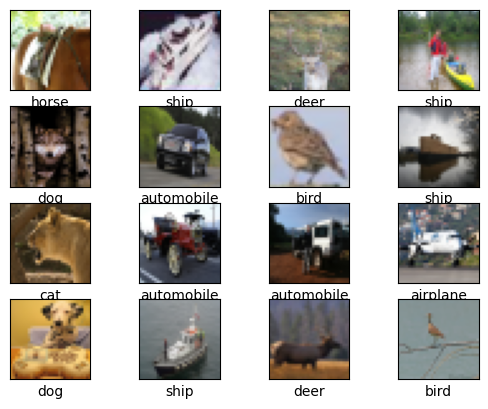

In [18]:
# check if images are properly loaded
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(training_images[i], cmap=plt.cm.binary)
    plt.xlabel(classes[training_labels[i]])
plt.show()

In [9]:
# create cnn model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))


model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [6]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation="relu", input_shape=(32, 32, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3, 3), activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [7]:
# fit model

model.fit(
    training_images,
    training_labels,
    epochs=25,
    validation_data=(test_images, test_labels),
)

Epoch 1/25
2813/2813 [==============================] - 29s 7ms/step - loss: 1.6242 - accuracy: 0.4117 - val_loss: 1.6359 - val_accuracy: 0.4366
Epoch 2/25
2813/2813 [==============================] - 20s 7ms/step - loss: 1.3040 - accuracy: 0.5305 - val_loss: 1.3817 - val_accuracy: 0.5094
Epoch 3/25
2813/2813 [==============================] - 20s 7ms/step - loss: 1.1729 - accuracy: 0.5809 - val_loss: 1.4516 - val_accuracy: 0.4900
Epoch 4/25
2813/2813 [==============================] - 20s 7ms/step - loss: 1.0779 - accuracy: 0.6181 - val_loss: 1.1346 - val_accuracy: 0.5964
Epoch 5/25
2813/2813 [==============================] - 20s 7ms/step - loss: 1.0054 - accuracy: 0.6455 - val_loss: 1.2426 - val_accuracy: 0.5636
Epoch 6/25
2813/2813 [==============================] - 20s 7ms/step - loss: 0.9475 - accuracy: 0.6655 - val_loss: 1.1171 - val_accuracy: 0.6151
Epoch 7/25
2813/2813 [==============================] - 20s 7ms/step - loss: 0.8903 - accuracy: 0.6863 - val_loss: 1.0832 - val_ac

KeyboardInterrupt: 

In [21]:
def save_model_with_version(model, base_path="models/cnn/"):
    pattern = r"v(\d+)"  # Regex to find version numbers
    max_version = 0
    
    # Check for existing models and find the highest version number
    if not os.path.exists(base_path):
        os.makedirs(base_path)
    for filename in os.listdir(os.path.dirname(base_path)):
        match = re.search(pattern, filename)
        if match:
            version = int(match.group(1))
            max_version = max(max_version, version)
    
    # Increment the version for the new model
    new_version = max_version + 1
    model_path = f"{base_path}cnn_v{new_version}.model"
    
    # Save the model
    model.save(model_path)
    print(f"Model saved as {model_path}")

In [22]:
#evaluate and save model
loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Loss: {loss}, Accuracy: {accuracy}")

save_model_with_version(model)

282/282 [==============================] - 1s 3ms/step - loss: 1.5349 - accuracy: 0.5674
Loss: 1.5349336862564087, Accuracy: 0.5674444437026978
INFO:tensorflow:Assets written to: models/cnn/cnn_v2.model\assets


INFO:tensorflow:Assets written to: models/cnn/cnn_v2.model\assets


Model saved as models/cnn/cnn_v2.model


In [11]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models

# Parameters
num_classes = 10  # Change as per your dataset
num_epochs = 10
data_dir = "/home/filip/pro1"  # Base directory for your dataset

# Load AlexNet
alexnet = models.alexnet(pretrained=True)
alexnet.classifier[6] = nn.Linear(alexnet.classifier[6].in_features, num_classes)

# Data Transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Data
train_dataset = datasets.ImageFolder(root=f'{data_dir}/train', transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = datasets.ImageFolder(root=f'{data_dir}/test', transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)

# Training and Validation Loops
for epoch in range(num_epochs):
    alexnet.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch + 1}, loss: {running_loss / len(train_loader)}')

    alexnet.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            outputs = alexnet(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy on validation set: {100 * correct / total}%')

print('Finished Training')


C:\Users\Filip\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Filip\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\Filip/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:37<00:00, 6.57MB/s] 


FileNotFoundError: [WinError 3] System nie może odnaleźć określonej ścieżki: '/home/filip/pro1/train'

In [12]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim
import torch.nn as nn
from torchvision.models import alexnet, AlexNet_Weights
from tqdm import tqdm

# Parameters
num_classes = 10  # Update to the number of classes in your dataset
num_epochs = 10
data_dir = "C:/Users/Filip/Desktop/PW/2 semestr/Deep Learning/pro1"  # Base directory for your dataset

# Load AlexNet
weights = AlexNet_Weights.IMAGENET1K_V1
alexnet_model = alexnet(weights=weights)
alexnet_model.classifier[6] = nn.Linear(alexnet_model.classifier[6].in_features, num_classes)

# Data Transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Data
train_dataset = datasets.ImageFolder(root=f'{data_dir}/train', transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = datasets.ImageFolder(root=f'{data_dir}/test', transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet_model.parameters(), lr=0.001, momentum=0.9)




In [13]:
# Training and Validation Loops with Progress Bar
for epoch in range(num_epochs):
    alexnet_model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    train_progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]', unit='batch')
    
    for inputs, labels in train_progress_bar:
        optimizer.zero_grad()
        outputs = alexnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        train_progress_bar.set_postfix(loss=train_loss/train_total, accuracy=100.*train_correct/train_total)

    # Validation
    alexnet_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_progress_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validate]', unit='batch')
    
    with torch.no_grad():
        for images, labels in val_progress_bar:
            outputs = alexnet_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_progress_bar.set_postfix(loss=val_loss/val_total, accuracy=100.*val_correct/val_total)

    print(f'End of Epoch {epoch + 1}, Training Loss: {train_loss / train_total}, Training Accuracy: {100. * train_correct / train_total}, Validation Loss: {val_loss / val_total}, Validation Accuracy: {100. * val_correct / val_total}')

print('Finished Training')

Epoch 1/10 [Validate]: 100%|██████████| 2813/2813 [19:05<00:00,  2.46batch/s, accuracy=75.7, loss=0.0213]


End of Epoch 1, Training Loss: 0.026417776319219006, Training Accuracy: 69.88555555555556, Validation Loss: 0.02130924410370903, Validation Accuracy: 75.69111111111111


Epoch 2/10 [Validate]: 100%|██████████| 2813/2813 [18:21<00:00,  2.55batch/s, accuracy=77.9, loss=0.0192]


End of Epoch 2, Training Loss: 0.02033062914311886, Training Accuracy: 76.75888888888889, Validation Loss: 0.01924486227799207, Validation Accuracy: 77.93777777777778


Epoch 3/10 [Validate]: 100%|██████████| 2813/2813 [18:42<00:00,  2.51batch/s, accuracy=78.8, loss=0.0186]


End of Epoch 3, Training Loss: 0.01751654570599397, Training Accuracy: 79.92111111111112, Validation Loss: 0.018627391978456743, Validation Accuracy: 78.83


Epoch 4/10 [Validate]: 100%|██████████| 2813/2813 [18:32<00:00,  2.53batch/s, accuracy=79.8, loss=0.0179]


End of Epoch 4, Training Loss: 0.015443899349371593, Training Accuracy: 82.21555555555555, Validation Loss: 0.017920093288846934, Validation Accuracy: 79.79777777777778


Epoch 5/10 [Validate]: 100%|██████████| 2813/2813 [18:33<00:00,  2.53batch/s, accuracy=80.7, loss=0.0171]


End of Epoch 5, Training Loss: 0.013645042623082797, Training Accuracy: 84.3411111111111, Validation Loss: 0.017140121312810678, Validation Accuracy: 80.67777777777778


Epoch 6/10 [Validate]: 100%|██████████| 2813/2813 [18:19<00:00,  2.56batch/s, accuracy=80.8, loss=0.0173]


End of Epoch 6, Training Loss: 0.012187241715565324, Training Accuracy: 85.89888888888889, Validation Loss: 0.017305650609337156, Validation Accuracy: 80.75555555555556


Epoch 7/10 [Validate]: 100%|██████████| 2813/2813 [18:59<00:00,  2.47batch/s, accuracy=81.2, loss=0.0171]


End of Epoch 7, Training Loss: 0.01072327620382938, Training Accuracy: 87.48333333333333, Validation Loss: 0.01711170478392289, Validation Accuracy: 81.18222222222222


Epoch 8/10 [Validate]: 100%|██████████| 2813/2813 [20:55<00:00,  2.24batch/s, accuracy=81.1, loss=0.0174]


End of Epoch 8, Training Loss: 0.009564009541066157, Training Accuracy: 88.85777777777778, Validation Loss: 0.017392713301203913, Validation Accuracy: 81.08


Epoch 9/10 [Validate]: 100%|██████████| 2813/2813 [20:55<00:00,  2.24batch/s, accuracy=81.3, loss=0.0175]


End of Epoch 9, Training Loss: 0.008369045110191736, Training Accuracy: 90.21444444444444, Validation Loss: 0.01748375713519959, Validation Accuracy: 81.27222222222223


Epoch 10/10 [Validate]: 100%|██████████| 2813/2813 [20:09<00:00,  2.33batch/s, accuracy=81.5, loss=0.0178]

End of Epoch 10, Training Loss: 0.00734495347150498, Training Accuracy: 91.53777777777778, Validation Loss: 0.017815081845983998, Validation Accuracy: 81.46
Finished Training


In [14]:
torch.save(alexnet_model.state_dict(), f'alexnet_epoch_{epoch}.pth')

NameError: name 'train_losses' is not defined

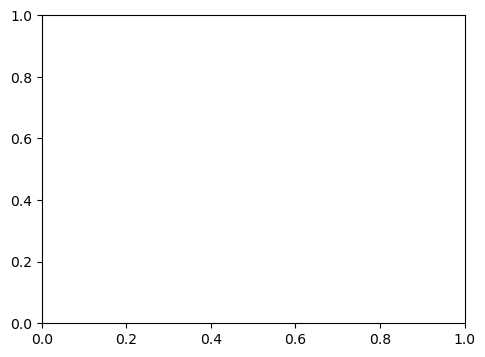

In [16]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
